In [1]:
import numpy as np
import pandas as pd
import matplotlib as plt
import urllib.request
from pulp import *

%matplotlib inline

In [2]:
t = pd.read_csv('../csv/stochastic_matrix.csv', index_col=0).fillna(0)

In [3]:
v = t.T[[
    'R00200', 'R00268', 'R00341', 'R00342', 'R00351',
    'R00405', 'R00658', 'R00703', 'R01015', 'R01049',
    'R01056', 'R01061', 'R01070', 'R01082', 'R01196', 
    'R01197', 'R01325', 'R01512', 'R01518', 'R01528',
    'R01529', 'R01641', 'R01786', 'R01830', 'R01899',
    'R01900', 'R02035', 'R02164', 'R02740', 'R04779'
]].T

for i in v.columns:
    if sum(v[i] == 0) == v.shape[0]:
        v = v.drop(i, axis=1)
        
v['C00007'] = pd.Series(np.zeros(v.shape[0]), index=v.index)
v['C00033'] = pd.Series(np.zeros(v.shape[0]), index=v.index)
v['C00092'] = pd.Series(np.zeros(v.shape[0]), index=v.index)
# v['C00279'] = pd.Series(np.zeros(v.shape[0]), index=v.index)

In [4]:
df = v.T
df['Glucose'] =  pd.Series(np.zeros(df.shape[0]), index=df.index)
df['Glucose']['C00267'] = 1

df['Oxygen'] =  pd.Series(np.zeros(df.shape[0]), index=df.index)
df['Oxygen']['C00007'] = 1

df['CO2'] =  pd.Series(np.zeros(df.shape[0]), index=df.index)
df['CO2']['C00011'] = -1

df['Lactate'] =  pd.Series(np.zeros(df.shape[0]), index=df.index)
df['Lactate']['C00186'] = -1

# df['Succinate'] =  pd.Series(np.zeros(df.shape[0]), index=df.index)
# df['Succinate']['C00042'] = -1

# df['Malate'] =  pd.Series(np.zeros(df.shape[0]), index=df.index)
# df['Malate']['C00149'] = -1

df['Fumarate'] =  pd.Series(np.zeros(df.shape[0]), index=df.index)
df['Fumarate']['C00122'] = -1

# df['Acetate'] =  pd.Series(np.zeros(df.shape[0]), index=df.index)
# df['Acetate']['C00033'] = -1

df['Glu_Exchange'] =  pd.Series(np.zeros(df.shape[0]), index=df.index)
df['Glu_Exchange']['C00267'] = -1
df['Glu_Exchange']['C00092'] = 1

df['acetyl_CoA_hydrolase'] =  pd.Series(np.zeros(df.shape[0]), index=df.index)
df['acetyl_CoA_hydrolase']['C00024'] = -1
df['acetyl_CoA_hydrolase']['C00001'] = -1
df['acetyl_CoA_hydrolase']['C00010'] = 1
df['acetyl_CoA_hydrolase']['C00033'] = 1

df['NADP_Exchange'] =  pd.Series(np.zeros(df.shape[0]), index=df.index)
df['NADP_Exchange']['C00005'] = -1
df['NADP_Exchange']['C00003'] = -1
df['NADP_Exchange']['C00006'] = 1
df['NADP_Exchange']['C00004'] = 1

df['ADP_Exchange'] =  pd.Series(np.zeros(df.shape[0]), index=df.index)
df['ADP_Exchange']['C00002'] = -1
df['ADP_Exchange']['C00008'] = 1

df['AMP_Exchange'] =  pd.Series(np.zeros(df.shape[0]), index=df.index)
df['AMP_Exchange']['C00002'] = -1
df['AMP_Exchange']['C00020'] = -1
df['AMP_Exchange']['C00008'] = 2

df['R00835'] =  pd.Series(np.zeros(df.shape[0]), index=df.index)
df['R00835']['C00092'] = -1
df['R00835']['C00006'] = -1
df['R00835']['C01236'] = 1
df['R00835']['C00005'] = 1
df['R00835']['C00080'] = 1

df['R08575'] =  pd.Series(np.zeros(df.shape[0]), index=df.index)
df['R08575']['C05382'] = -1
df['R08575']['C00118'] = -1
df['R08575']['C00279'] = 1
df['R08575']['C00085'] = 1

df['R02164']['C00004'] = -1
df['R02164']['C00003'] = 1
df['R02164']['C15602'] = 0
df['R02164']['C15603'] = 0

# Oxophos
df['Oxophos'] =  pd.Series(np.zeros(df.shape[0]), index=df.index)
df['Oxophos']['C00004'] = -2
df['Oxophos']['C00007'] = -1
df['Oxophos']['C00008'] = -5
df['Oxophos']['C00002'] = 5
df['Oxophos']['C00003'] = 2
df['Oxophos']['C00011'] = 1

In [5]:
BIOMASS = pd.read_csv('../csv/amino_acid.csv',index_col=0)
BIOMASS = BIOMASS[BIOMASS.index != 'NH3']
df_Biomass =  pd.Series(np.zeros(df.shape[0]), index=df.index)

for i in BIOMASS.index:
    df_Biomass[BIOMASS.T[i]['C_num']] = BIOMASS.T[i]['flux']
    
df_Biomass['C00668'] = -0.27519
df_Biomass['C00119'] = (-0.039036) + (-0.036117) + (-0.053446)

In [6]:
df_new = pd.concat([df_Biomass.T, df], axis=1)
df_new = df_new.rename(columns={0: 'BIOMASS'})
df_new = df_new.drop([
    'C00001','C00009','C00080','C00138','C00139','C15602','C15603', 
#     'C00231'
])

df_new = df_new.sort_index()

In [7]:
rate = pd.DataFrame()
for l in range(0, 1000, 1):
    x = []
    for i in df_new.columns:
        if (
                (i=='Oxophos') or (i=='R01899') or (i=='R00268') or (i=='R10343') or (i=='R02164') or (i=='R00835') or (i=='R02035') or
                (i=='CO2') or (i == 'Lactate') or (i == 'Acetate') or (i == 'Succinate') or (i == 'Malate') or (i=='ATP_Exchange') or (i=='AMP_Exchange')
            ) :
            x.append(LpVariable(i, lowBound=0,upBound=10000, cat='Continuous'))

        elif (i=='Glucose'):
            x.append(LpVariable(i, lowBound=0, upBound=100, cat='Continuous'))

        elif (i=='Fumarate'):
            x.append(LpVariable(i, lowBound=0, upBound=10000, cat='Continuous'))    

        elif (i=='Oxygen'):
            x.append(LpVariable(i, lowBound=0, upBound=l, cat='Continuous'))

        elif (i=='R00200') or (i=='R01196') or (i=='R01197') or (i=='R00405'):
            x.append(LpVariable(i, lowBound=-10000, upBound=0, cat='Continuous'))

        else:
            x.append(LpVariable(i, lowBound=-10000, upBound=10000, cat='Continuous'))

    m = LpProblem(sense=LpMaximize)
    m += x[0]

    for i in np.dot(df_new, x):
        m += i == 0

    status = m.solve()
    print(LpStatus[status])

    y = []
    for i in x:
        y.append(i.value())

    rate = pd.concat([rate,pd.DataFrame(y, index=x).T])

Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal


In [8]:
rate.columns = [str(i) for i in list(rate.columns)]
rate.index = range(0, 1000)

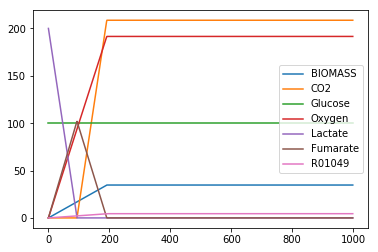

In [9]:
rate[['BIOMASS','CO2','Glucose','Oxygen', 'Lactate', 'Fumarate', 'R01049']].plot()

In [11]:
rate.T[[80,150,400]].to_csv('../result/graph_for_poster.csv')

,80,150,400
BIOMASS,14.496308,27.180578,34.711074
R00200,-58.174261,-54.068692,-69.048656
R00268,21.506868,40.325377,51.497696
R00341,-117.805790,-100.893910,-73.436136
R00342,-81.928879,-33.624694,12.470300
R00351,-21.506868,-40.325377,-51.497696
R00405,0.000000,0.000000,0.000000
R00658,175.980050,154.962600,142.484790
R00703,-29.337625,0.000000,0.000000
R01015,-95.389357,-91.355045,-88.959923
